In [1]:
import os
import configparser

import numpy as np
import pandas as pd

from source.processes import Shuffler
from source.datamodels.datamodels import GridSearchResults
from source.datamodels.datamodels import Axes, Stats
from source.utils import get_project_root

In [6]:
root = get_project_root()
config = configparser.ConfigParser()
config.read(os.path.join(root, "userconfig.ini"))

own_data_path = config['Path']['own_data_path']
third_party_data_path = config['Path']['third_party_data_path']
Cesar1_path = config['Path']['Cesar1_path']

images_path = config['Path']['images_path']
public_images_path = config['Path']['public_images_path']

tables_path = config['Path']['tables_path']
public_tables_path = config['Path']['public_tables_path']

bootstrap_jsons_path = config['Path']['bootstrap_jsons_path']
single_jsons_path = config['Path']['single_jsons_path']

In [16]:
prepared_data = pd.read_csv(os.path.join(root, own_data_path, 'processed_full_signal_specter1000.csv'), delimiter=',')  # our experiment
prepared_data.head()

,target,group,a1_x_signal_range,a1_x_signal_std,a1_x_signal_kurtosis,a1_x_signal_variation,a1_x_signal_shannon_entropy,a1_x_signal_energy,a1_x_signal_sample_entropy,a1_x_signal_crest_factor,...,a2_z_specter_crest_factor,a2_z_specter_activity,a2_z_specter_hurst,a2_z_specter_higuchi_fd,a2_z_specter_skew,a2_z_specter_iqr,a2_z_specter_petrosian_fd,a2_z_specter_complexity,a2_z_specter_mean,a2_z_specter_zero_crossing
0,0.0,1.0,13.371285,2.078757,-0.337526,-9.989303,6.388020,11784.249294,2.752303,3.583394,...,11.710311,1.067684,0.735075,1.813171,6.747578,2.625193,1.035657,1.555520,7.685173,0.0
1,0.0,1.0,13.659874,2.260749,-0.329388,-8.479932,6.507361,13991.570232,2.840346,3.050062,...,13.562794,1.142286,0.695679,1.867153,8.574395,2.555386,1.035379,1.446775,6.815131,0.0
2,0.0,1.0,13.178892,2.237654,-0.439591,-9.585973,6.489806,13666.278173,2.842011,3.156487,...,15.268013,1.173990,0.670514,1.869799,10.055632,2.404519,1.033761,1.450265,7.053626,0.0
3,0.0,1.0,12.216929,2.098390,-0.364524,-9.033494,6.422261,12034.432981,2.759454,3.090305,...,18.815380,1.303795,0.598747,1.909137,14.348368,2.309265,1.035268,1.334886,7.714920,0.0
4,0.0,1.0,15.391407,2.155084,0.017384,-8.482620,6.449559,12714.120421,2.772840,3.760177,...,15.595560,1.211011,0.631251,1.891693,11.303165,2.404522,1.035879,1.368436,7.167567,0.0


In [17]:
# models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [18]:
LR_estimator = LogisticRegression(max_iter=100000)
SVC_estimator = SVC()
RFC_estimator = RandomForestClassifier()
GBM_estimator = GradientBoostingClassifier()
KNN_estimator = KNeighborsClassifier()

In [19]:
LR_grid = {"C": list(np.logspace(-3, 6, 10))}  # np.ndarrays are not serializable
SVC_grid = {"C": list(np.logspace(-3, 6, 10)), 'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}
RFC_grid = {'n_estimators': [50, 100, 200, 300], 'max_depth': [3, 5, 9, 15, 30]}
GBM_grid = {'learning_rate': list(np.logspace(-3, 4, 8)), 'n_estimators': [50, 100, 200, 300], 'max_depth': [3, 5, 9, 15, 30]}
KNN_grid = {'n_neighbors': [1, 3, 5, 7, 9, 15, 35], 'p': [1, 1.5, 2, 2.5, 6, 100]}

In [20]:
X = prepared_data.drop(columns=['target', 'group']).values
y = prepared_data['target'].values
groups = prepared_data['group'].values

X_scaled = StandardScaler().fit_transform(X)

In [22]:
from datetime import datetime

GS_results_objects = []

estimators = [LR_estimator, SVC_estimator, RFC_estimator, GBM_estimator, KNN_estimator]
grids = [LR_grid, SVC_grid, RFC_grid, GBM_grid, KNN_grid]
names = ['LR', 'SVC', 'RFC', 'GBM', 'KNN']

n_repeats = 100
score_name = 'f1'

for estimator, grid, name in zip(estimators, grids, names):
    json_grid = dict()
    for key, val in zip (grid.keys(), grid.values()):
        if isinstance(val, np.ndarray):
            json_grid[key] = list(val)
        else:
            json_grid[key] = val
    start_time = datetime.now()
    cv = Shuffler.OverlapGroupCV(train_size=0.63, n_repeats=n_repeats).split(X_scaled, y, groups)
    GSCV = GridSearchCV(estimator, grid, scoring=score_name, cv=cv)
    GSCV.fit(X_scaled, y, groups=groups)

    print(f"Best {score_name} score for {name}: {100*GSCV.best_score_:.3f}% \n best params: {GSCV.best_params_}\n required time: {datetime.now() - start_time}")

    highest_score_params = GSCV.cv_results_['rank_test_score'][0]
    split_scores_names = [f'split{idx}_test_score' for idx in range(n_repeats)]

    scores_distr = []
    for split_scores_name in split_scores_names:
        scores_distr.append(float(GSCV.cv_results_[split_scores_name][highest_score_params-1]))
    res = GridSearchResults(
        run_label = "GS",
        model_name = name,
        hyperparameters = GSCV.best_params_,
        hyperparameters_grid = json_grid,
        use_signal = True,
        use_specter = True,
        specter_threshold = 500,
        axes = Axes.get_keys(),
        stats = Stats.get_keys(),
        predictions = None,
        scores = {score_name: float(GSCV.best_score_)},
        resampling_number = n_repeats,
        bootstrap_scores =  {score_name: scores_distr}
    )
    GS_results_objects.append(res)

Best f1 score for LR: 80.600% 
 best params: {'C': 10000.0}
 required time: 0:00:26.785812
Best f1 score for SVC: 79.542% 
 best params: {'C': 0.1, 'kernel': 'linear'}
 required time: 0:01:11.942712
Best f1 score for RFC: 76.496% 
 best params: {'max_depth': 15, 'n_estimators': 300}
 required time: 0:14:54.941539
Best f1 score for GBM: 76.645% 
 best params: {'learning_rate': 0.01, 'max_depth': 30, 'n_estimators': 200}
 required time: 18:39:51.354854
Best f1 score for KNN: 76.802% 
 best params: {'n_neighbors': 1, 'p': 1.5}
 required time: 1:20:13.148770


##

In [23]:
from source.postprocessing.mljson import serialize_results


serialize_results(GS_results_objects, filenames=[f"{model}_GS_AFull_signal_specter1000_02_10_2021.json" for model in names], filepath=os.path.join(root, bootstrap_jsons_path, 'GridSearch'))

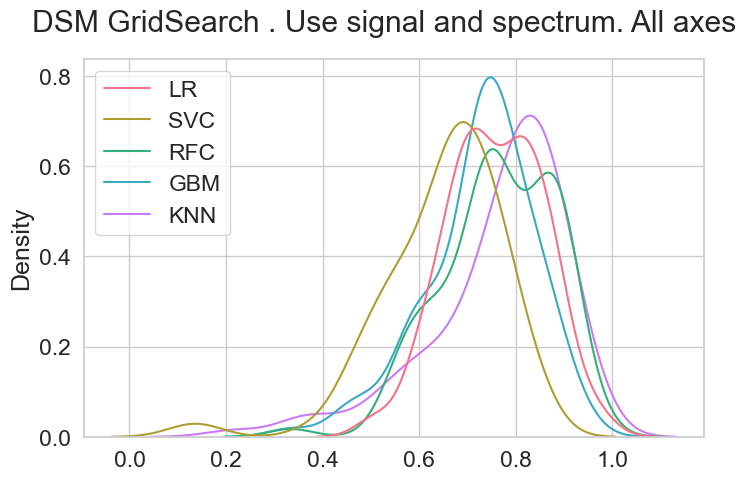

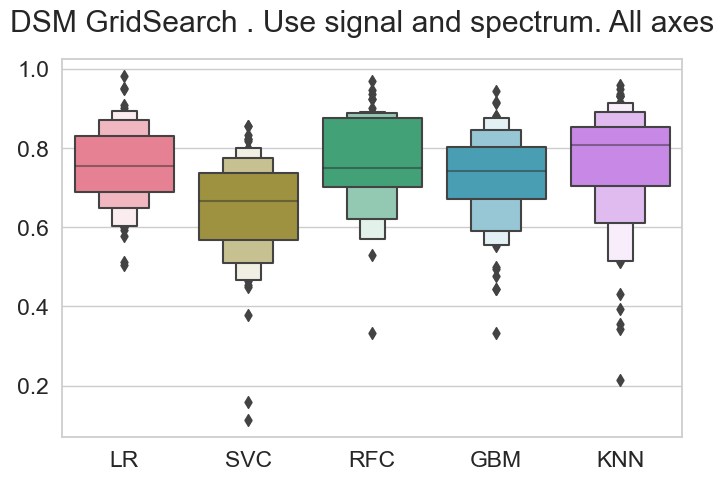

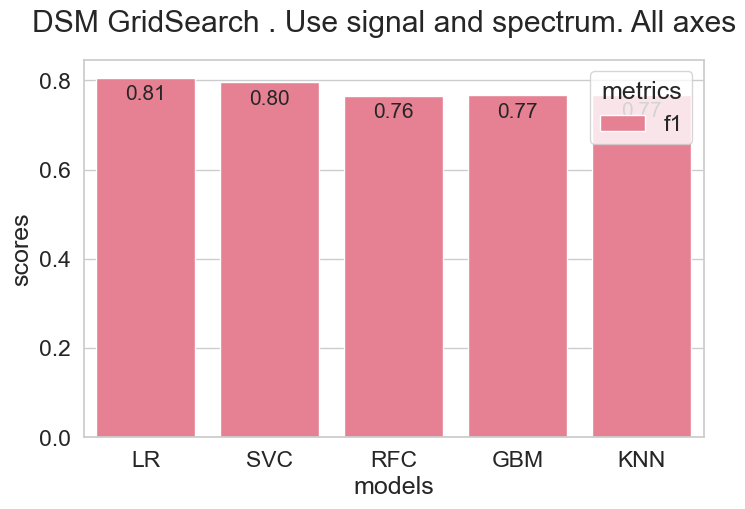

In [24]:
from source.postprocessing.plotter import dist_plot, bar_plot


plot_info = '. Use signal and spectrum. All axes'
filename_info = 'GS'
dist_plot(results=GS_results_objects, models=names, plot_type='kdeplot', metric='f1', title=f'DSM GridSearch {plot_info}', to_png=True, filename=f'kde_DSM_{filename_info}_2_11_2021.png', filepath=os.path.join(root, images_path, 'DSM_GS'))

dist_plot(results=GS_results_objects, models=names, plot_type='boxenplot', metric='f1', title=f'DSM GridSearch {plot_info}', to_png=True, filename=f'box_DSM_{filename_info}_2_11_2021.png', filepath=os.path.join(root, images_path, 'DSM_GS'))

bar_plot(results=GS_results_objects, models=names, metrics=['f1'], title=f'DSM GridSearch {plot_info}', plot_vals=True, to_png=True, filename=f'bar_DSM_{filename_info}_2_11_2021.png', filepath=os.path.join(root, images_path, 'DSM_GS'))

In [27]:
from source.postprocessing.mlcsv import generate_csv_from_results, append_results_to_csv, create_readable_xlsx
from source.postprocessing.mljson import deserialize_results

# generate_csv_from_results(GS_results_objects, "DSM_GS.csv", results_type=GridSearchResults, csv_path=os.path.join(root, tables_path))
# append_results_to_csv(GS_results_objects, "DSM_GS.csv", results_type=GridSearchResults, csv_path=os.path.join(root, tables_path))
whole_results = deserialize_results(GridSearchResults, filepath=os.path.join(root, bootstrap_jsons_path, 'GridSearch'))
generate_csv_from_results(whole_results, "DSM_GS.csv", results_type=GridSearchResults, csv_path=os.path.join(root, tables_path))
create_readable_xlsx("GridSearch results.xlsx", "DSM_GS.csv", csv_path=os.path.join(root, tables_path), xlsx_path=os.path.join(root, tables_path, 'public'))